In [4]:
#import packages
import ast
import swifter
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
import pandas as pd

In [ ]:
#notes:
#Blame and praise
# entailsments
#does not entail an actually entailment

#Blame vs endorsement
#Also report initial inspection of model wher praise and neutral was added to the hypothesis paramenter instead of blame/not blame.
# something about hieracivcal order and the words not being complete opisats and therefore the relative probabilities entails needed information
# in addition to the absolute probability

In [5]:
#define functions


def extract_blame_from_paragraph_lookup(input_str):
    """
    Returns a binary list for blame per sentence:
    1 if blame is highest among labels and >= 0.8, else 0
    Handles arbitrary label order.
    """
    try:
        
        sentence_list = ast.literal_eval(input_str)
    except Exception:
        return []

    # List comprehension is faster than appending in a loop
    blame_binary = [
        int(
            (label_score := {label: score for label, score in zip(sent['labels'], sent['scores'])})['blame']
            >= max(label_score.get('praise', 0.0), label_score.get('neutral', 0.0), 0.8)
        )
        for sent in sentence_list
    ]


    return blame_binary

#example usage: final_data['blame_binary'] = final_data['blame_in_text'].swifter.apply(extract_blame_from_paragraph_lookup)


#get row indices (paragraphs) that contain blame
def get_rows_with_blame(df, col="blame_binary"):
    """
    Returns row indices where the list in `col` contains at least one 1.
    Handles both real lists and stringified lists.
    """
    indices = []
    for i, values in zip(df.index, df[col]):
        if isinstance(values, str):  # convert only if it's a string
            values = ast.literal_eval(values)
        if 1 in values:
            indices.append(i)
    return indices

#example usage: row_indices = get_rows_with_blame(final_data, col="blame_binary")
#print(row_indices[:10])


#get paragraphs and sentence indices of blame True
def get_rows_and_positions(df, col="blame_binary"):
    """
    Returns {row_index: [positions_of_1s]}.
    Handles both real lists and stringified lists.
    """
    results = {}
    for i, values in zip(df.index, df[col]):
        if isinstance(values, str):
            values = ast.literal_eval(values)
        ones = [j for j, v in enumerate(values) if v == 1]
        if ones:
            results[i] = ones
    return results

#example usage: rows_with_positions = get_rows_and_positions(final_data, col="blame_binary")
#print(rows_with_positions)

#
#get danish sentences containing blame from indices extracted as above

def danish_sentences_with_blame_extraction(dict, data, text_column):


    rows = list(dict.keys())
    sentences = {}

    for para in rows:
        sentence_indices = dict[para]
        text_sentences = ast.literal_eval(data.loc[para][text_column])
        
        blame_sentence_dict = {}
        for indx in sentence_indices:
            blame_sentence = text_sentences[indx]
            blame_sentence_dict[indx] = blame_sentence
        
        
        sentences[para] = blame_sentence_dict

    return sentences


#example usage: danish_sentences_with_blame = danish_sentences_with_blame_extraction(rows_with_positions, final_data, 'da_segmented_text')


#extract blame percentage:

import ast

def total_blame_percentage(string_rows):
    """
    Calculate the total percentage of blame-sentences across all rows,
    converting string representations of lists into actual lists.
    
    Parameters
    ----------
    string_rows : list of str
        Each element is a string like '[1, 0, 1]' representing a row of blame labels.

    Returns
    -------
    float
        Total percentage of blame-sentences (0–100).
    """
    total_sentences = 0
    total_blame = 0

    for row_str in string_rows:
        try:
            row = row_str  # convert string to list
            #row = ast.literal_eval(row_str)
            if not isinstance(row, list):
                continue  # skip if not a list
            row = [int(val) for val in row]  # ensure integers
            total_sentences += len(row)
            total_blame += sum(row)
        except (ValueError, SyntaxError):
            continue  # skip invalid rows

    if total_sentences == 0:
        return 0.0

    return (total_blame / total_sentences) * 100, total_sentences, total_blame

#Example usage: percentage_blame, total_sent, total_blame= total_blame_percentage(final_data['blame_binary'])

#extract blame scores

def get_blame_scores(data, blame_in_text_column = 'blame_in_text'):
    all_blame_scores = []

    for i in range(len(data)):
        dict_labels = ast.literal_eval(data.loc[i][blame_in_text_column])

        blame_list = [(label_score := {label: score for label, score in zip(sent['labels'], sent['scores'])})['blame'] for sent in dict_labels]

        all_blame_scores +=blame_list
    return all_blame_scores


#make vizualization of the distribution

def vizualize_blame_prob(blame_scores):
    len_blame_scores = len(blame_scores)
    fig, axs = plt.subplots(len_blame_scores, 2, figsize=(12, 10))
    for i in range(len_blame_scores):
        axs[i,0].hist(blame_scores[i], log = True, bins = 50)
        axs[0, 0].set_title('Log transformed y axis')
        axs[i,1].hist(blame_scores[i], bins = 50)
        axs[0, 1].set_title('absolute y-axis')

    fig.suptitle('Distribution of blame probabilities by template (log transformed counts/absolute counts)')

    for ax in axs.flat:
        ax.set(xlabel='probability', ylabel='count')
    fig.show()


In [6]:
#Data with all templates


all_templates_data = pd.read_csv("/work/MarkusLundsfrydJensen#1865/Bachelor_project/annotation_data_fifth_template_appended.csv")

all_templates_data.head()

,Unnamed: 0,date,agenda,speechnumber,speaker,party,party.facts.id,chair,terms,text,parliament,iso3country,da_segmented_text,translated_text,blame_in_text,second_template_blame_in_text,third_template_blame_in_text,fourth_template_blame_in_text,fifth_template_blame_in_text
0,0,1997-10-07,Dagsorden,1,Gert Petersen,NaN,NaN,True,191,Mødet er åbnet. I henhold til grundloven er Fo...,DK-Folketing,DNK,"['Mødet er åbnet.', 'I henhold til grundloven ...","['The meeting is open.', 'Under the Constituti...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'...","[{'sequence': 'The meeting is open.', 'labels'..."
1,1,1997-10-07,Dagsorden,2,Formanden,NaN,NaN,True,182,"Jeg vil gerne takke Tinget for den tillid, man...",DK-Folketing,DNK,"['Jeg vil gerne takke Tinget for den tillid, m...",['I would like to thank Things for the confide...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...,[{'sequence': 'I would like to thank Things fo...
2,2,1997-10-07,Statsministerens redegørelse i henhold til gru...,3,Poul Nyrup Rasmussen,S,379.0,False,18662,For 25 år siden sagde et flertal i befolkninge...,DK-Folketing,DNK,['For 25 år siden sagde et flertal i befolknin...,"['Twenty-five years ago, a majority of the peo...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori...","[{'sequence': 'Twenty-five years ago, a majori..."
3,3,1997-10-09,1) Indstilling fra Udvalget til Valgs Prøvelse.,2,Formanden,NaN,NaN,True,47,Fra Udvalget til Valgs Prøvelse har jeg modtag...,DK-Folketing,DNK,"['Fra Udvalget til Valgs', 'Prøvelse', 'har je...",['From the Committee to the Committee of the R...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...,[{'sequence': 'From the Committee to the Commi...
4,4,1997-10-09,2) Forhandling om redegørelse nr. R 1.,3,Torben Lund,S,379.0,False,2865,Vi står over for en meget afgørende folketings...,DK-Folketing,DNK,['Vi står over for en meget afgørende folketin...,['We are faced with a very crucial parliamenta...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...,[{'sequence': 'We are faced with a very crucia...


In [7]:
blame_columns = ["blame_in_text","second_template_blame_in_text","third_template_blame_in_text","fourth_template_blame_in_text","fifth_template_blame_in_text"]


In [ ]:
#Sanity checks:
#check if translated, orignal and blame probabilty are same lengt (extend for all templates)

for column in blame_columns:
    for indx in range(len(all_templates_data)):

        temo = all_templates_data.loc[indx]

        l_da = len(ast.literal_eval(temo['da_segmented_text']))
        l_en = len(ast.literal_eval(temo['translated_text']))
        l_bl = len(ast.literal_eval(temo[column]))

        if l_da != l_en != l_bl:
            print(column)
            print(temo)

In [ ]:

# apply extract blame from paragraph lookup function in order to evaulate blame from PolDebate probabilities

for i, column in enumerate(blame_columns):
    all_templates_data[f'blame_binary_temp_{i+1}'] = all_templates_data[column].swifter.apply(extract_blame_from_paragraph_lookup)

all_templates_data.head()

Pandas Apply:   0%|          | 0/36314 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd62defecf0>>
Traceback (most recent call last):
  File "/work/MarkusLundsfrydJensen#1865/miniconda3/envs/blame_bert/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Pandas Apply:   0%|          | 0/36314 [00:00<?, ?it/s]

In [1]:
print('hello')

hello


In [2]:
#Do vizualization of blame probability distribution for all templates
#alter function to make it subplots

all_blame_scores = []

for column in blame_columns:
    all_blame_scores.append(get_blame_scores(all_templates_data, blame_in_text_column = column))

NameError: name 'blame_columns' is not defined

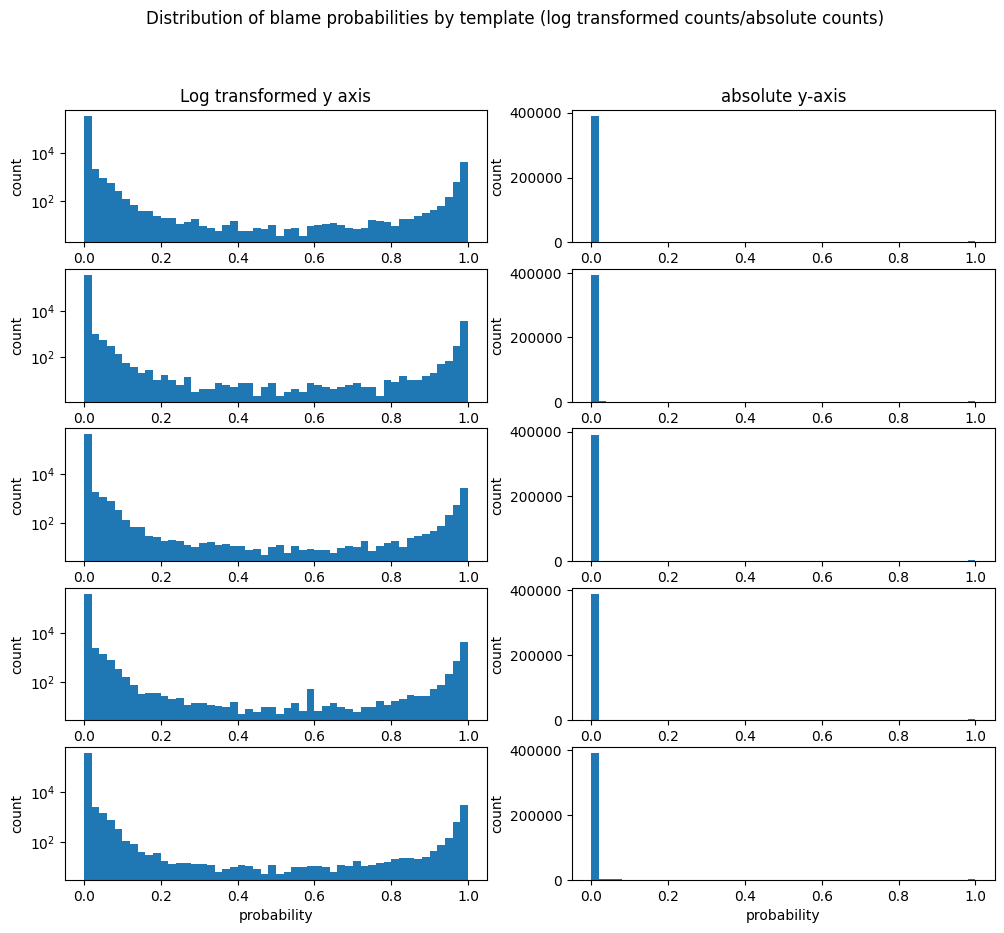

In [ ]:
vizualize_blame_prob(all_blame_scores)

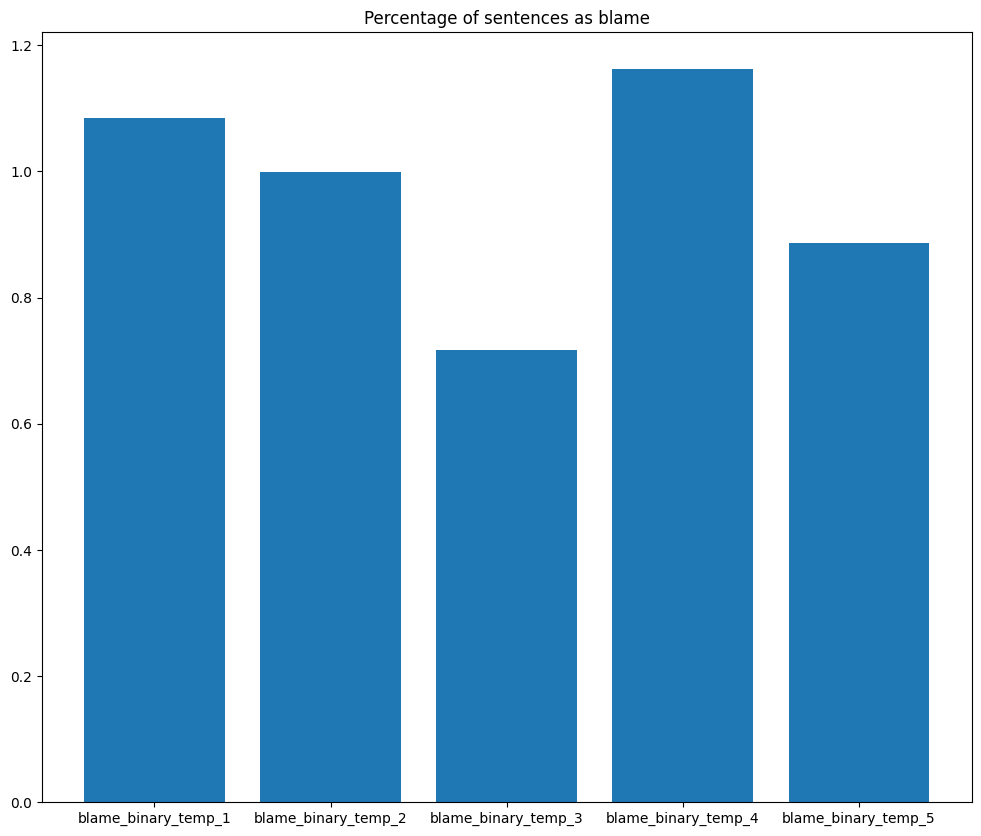

In [ ]:
#Get percentage of blame for each template

plt.figure(figsize=(12, 10))

blame_percentage = []
abs_blame = []
template_name = []
for i in range(1,6):
    temp_name = f'blame_binary_temp_{i}'
    percentage_blame, total_sent, total_blame= total_blame_percentage(all_templates_data[temp_name])

    blame_percentage.append(percentage_blame)
    abs_blame.append(total_blame)
    template_name.append(temp_name)





plt.bar(template_name, blame_percentage)
plt.title('Percentage of sentences as blame')


fig.suptitle('Bar plot of blame percentage by template')

#for ax in axs.flat:
#    ax.set(xlabel='probability', ylabel='count')
fig.show()

In [ ]:
#Get data and do vizualization of the overlapping blame
# How much of the total blame by all templates do 4/3/2/1 templates agree upon
# Extract this information on a sentence level df['agreement_degree] maybe in format paragraph_i = [0,0,4,3,2,0,0,1]


In [ ]:
blame_indices_template_1 = rows_with_positions = get_rows_and_positions(all_templates_data, col=blame_columns[0])
blame_indices_template_2 = rows_with_positions = get_rows_and_positions(all_templates_data, col=blame_columns[1])
blame_indices_template_3 = rows_with_positions = get_rows_and_positions(all_templates_data, col=blame_columns[2])
blame_indices_template_4 = rows_with_positions = get_rows_and_positions(all_templates_data, col=blame_columns[3])
blame_indices_template_5 = rows_with_positions = get_rows_and_positions(all_templates_data, col=blame_columns[4])

In [ ]:
blame_indices_template_2

{}